# Init

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'src/')

from collections import namedtuple

import torch 
from torch.utils.data import Dataset, DataLoader, random_split
import joblib
from torch import nn 
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

from reward_evaluation import RewardComparision
from architecture.reward import StateDataset, EpisodeDataset, ImbalancedDatasetSampler, RewardModel
from architecture.language_model import LanguageModel
from simulator.description_embedder import Description_embedder
from simulator.Environment import preprocess_raw_observation
from simulator.Items import ITEM_TYPE
from config import generate_params

params = generate_params(save_path=False)

description_embedder = Description_embedder(**params['env_params']['description_embedder_params'])

item_type_embedder = OneHotEncoder(sparse=False)
item_type_embedder.fit(np.array(ITEM_TYPE).reshape(-1, 1))

from functools import partial
transformer = partial(preprocess_raw_observation, description_embedder=description_embedder, item_type_embedder=item_type_embedder, raw_state_size=3, 
                      pytorch=True, device=params['device'])

In [3]:
# EpisodeRecord = namedtuple('EpisodeRecord', ('initial_state', 'final_state', 'instruction', 'reward'))
# episode_path = 'results/episodes_records.jbl'
# episodes = joblib.load(episode_path)

StateRecord = namedtuple('StateRecord', ('state', 'instruction', 'reward'))
EpisodeRecord = namedtuple('EpisodeRecord', ('initial_state', 'final_state', 'instruction', 'reward'))

state_path = 'results/state_records3.jbl'
train_episode = 'results/episodes_records4.jbl'
test_episode = 'results/episodes_records3.jbl'

# Code

## Reward training

### Load data

In [4]:
# dts = StateDataset.from_files(state_path, raw_state_transformer=transformer, max_size=5000)
# dts = EpisodeDataset.from_files(episode_path, raw_state_transformer=transformer)
# dts_loader = DataLoader(dts, batch_size=len(dts))
# train_dts, test_dts = dts.split(train_test_ratio = 0.85)

train_dts = EpisodeDataset.from_files(train_episode, raw_state_transformer=transformer)
test_dts = EpisodeDataset.from_files(test_episode, raw_state_transformer=transformer, max_size=5000)

sampler = ImbalancedDatasetSampler(train_dts, num_samples=20000, pos_weight=0.2)
# train_loader = DataLoader(dataset=train_dts, sampler=sampler, batch_size=128)
test_loader = DataLoader(test_dts, batch_size=len(test_dts))
test_batch = next(iter(test_loader))

### Initialize model 

In [7]:
language_model = LanguageModel(**params['language_model_params'])
reward_function = LearnedReward(context_model=params['model_params']['context_model'], language_model=language_model, reward_params=params['reward_model_params'])
reward_function.to(params['device'])

from torch import optim
loss_func = nn.BCELoss()
optimizer = optim.Adam(reward_function.parameters())

### Training

In [19]:
from tqdm.notebook import tqdm
from torch.nn.utils import clip_grad_norm_

for epoch in range(100):
    for i, batch in tqdm(enumerate(train_loader)):
#         print(batch['reward'].float().mean())
        optimizer.zero_grad()
        reward = reward_function(state=batch['state'], instructions=batch['instruction']).view(-1)
        loss = loss_func(reward, batch['reward'].float().to(params['device']))
        print(f'{epoch} {i} loss: {loss.item()}')
        loss.backward()
#         clip_grad_norm_(reward_function.parameters(), 1)
        optimizer.step()
        
    

0 0 loss: 0.05711089447140694
0 1 loss: 0.0653453916311264
0 2 loss: 0.061978090554475784
0 3 loss: 0.053842462599277496
0 4 loss: 0.074861079454422
0 5 loss: 0.07310312986373901
0 6 loss: 0.0656624585390091
0 7 loss: 0.08667128533124924
0 8 loss: 0.07506480067968369
0 9 loss: 0.1087091863155365
0 10 loss: 0.038395702838897705
0 11 loss: 0.04237275943160057
0 12 loss: 0.04104701429605484
0 13 loss: 0.07748584449291229
0 14 loss: 0.07600108534097672
0 15 loss: 0.1359160989522934
0 16 loss: 0.053344376385211945
0 17 loss: 0.04987293854355812
0 18 loss: 0.07306171953678131
0 19 loss: 0.064381904900074
0 20 loss: 0.05508366972208023
0 21 loss: 0.10977333039045334
0 22 loss: 0.056368082761764526
0 23 loss: 0.04375394433736801
0 24 loss: 0.04222206771373749
0 25 loss: 0.031051531434059143
0 26 loss: 0.0839010626077652
0 27 loss: 0.06733690202236176
0 28 loss: 0.07599324733018875
0 29 loss: 0.06937453150749207
0 30 loss: 0.07159052789211273
0 31 loss: 0.057998619973659515
0 32 loss: 0.0359527

1 0 loss: 0.09296280145645142
1 1 loss: 0.08203186094760895
1 2 loss: 0.024309052154421806
1 3 loss: 0.0258091501891613
1 4 loss: 0.06984315067529678
1 5 loss: 0.07733271270990372
1 6 loss: 0.0597383975982666
1 7 loss: 0.09382972121238708
1 8 loss: 0.12280167639255524
1 9 loss: 0.014874305576086044
1 10 loss: 0.10073670744895935
1 11 loss: 0.015416206791996956
1 12 loss: 0.058806151151657104
1 13 loss: 0.06679844856262207
1 14 loss: 0.07519792020320892
1 15 loss: 0.0751529112458229
1 16 loss: 0.05818849056959152
1 17 loss: 0.07148868590593338
1 18 loss: 0.12956681847572327
1 19 loss: 0.06178022921085358
1 20 loss: 0.024018920958042145
1 21 loss: 0.053804103285074234
1 22 loss: 0.03466997295618057
1 23 loss: 0.02485303208231926
1 24 loss: 0.028028912842273712
1 25 loss: 0.04680359736084938
1 26 loss: 0.06093886122107506
1 27 loss: 0.06623439490795135
1 28 loss: 0.06572945415973663
1 29 loss: 0.04558172821998596
1 30 loss: 0.01725270226597786
1 31 loss: 0.03375369310379028
1 32 loss: 0.0

2 0 loss: 0.03337174654006958
2 1 loss: 0.04682227596640587
2 2 loss: 0.03618162125349045
2 3 loss: 0.032740119844675064
2 4 loss: 0.04480356350541115
2 5 loss: 0.042017433792352676
2 6 loss: 0.041028186678886414
2 7 loss: 0.03448895364999771
2 8 loss: 0.04038792848587036
2 9 loss: 0.017448697239160538
2 10 loss: 0.04377584159374237
2 11 loss: 0.04479197412729263
2 12 loss: 0.019688330590724945
2 13 loss: 0.0472196526825428
2 14 loss: 0.061010461300611496
2 15 loss: 0.03218396008014679
2 16 loss: 0.034729816019535065
2 17 loss: 0.00994601659476757
2 18 loss: 0.06617330014705658
2 19 loss: 0.04089813306927681
2 20 loss: 0.03483204171061516
2 21 loss: 0.06146489828824997
2 22 loss: 0.06752562522888184
2 23 loss: 0.045651137828826904
2 24 loss: 0.050140395760536194
2 25 loss: 0.030463771894574165
2 26 loss: 0.04521387815475464
2 27 loss: 0.07195288687944412
2 28 loss: 0.06800715625286102
2 29 loss: 0.07367274165153503
2 30 loss: 0.04514716938138008
2 31 loss: 0.046817611902952194
2 32 los

3 0 loss: 0.08428271114826202
3 1 loss: 0.027456112205982208
3 2 loss: 0.09462219476699829
3 3 loss: 0.01566447876393795
3 4 loss: 0.04718851298093796
3 5 loss: 0.027409913018345833
3 6 loss: 0.08315487951040268
3 7 loss: 0.05002908036112785
3 8 loss: 0.04749758541584015
3 9 loss: 0.06074657291173935
3 10 loss: 0.05208876356482506
3 11 loss: 0.007057345937937498
3 12 loss: 0.04072653502225876
3 13 loss: 0.016785304993391037
3 14 loss: 0.02056990936398506
3 15 loss: 0.03867800161242485
3 16 loss: 0.015535256825387478
3 17 loss: 0.04713313281536102
3 18 loss: 0.009257483296096325
3 19 loss: 0.03119269385933876
3 20 loss: 0.013982422649860382
3 21 loss: 0.09666761755943298
3 22 loss: 0.015513461083173752
3 23 loss: 0.030811738222837448
3 24 loss: 0.05484171211719513
3 25 loss: 0.014986051246523857
3 26 loss: 0.02442403882741928
3 27 loss: 0.015021842904388905
3 28 loss: 0.017285803332924843
3 29 loss: 0.06836239248514175
3 30 loss: 0.02588675729930401
3 31 loss: 0.0904235988855362
3 32 lo

4 0 loss: 0.04151609167456627
4 1 loss: 0.016714025288820267
4 2 loss: 0.03581998497247696
4 3 loss: 0.051441218703985214
4 4 loss: 0.03564375266432762
4 5 loss: 0.028141947463154793
4 6 loss: 0.017577195540070534
4 7 loss: 0.10522892326116562
4 8 loss: 0.01462179608643055
4 9 loss: 0.013045523315668106
4 10 loss: 0.024240415543317795
4 11 loss: 0.05541915446519852
4 12 loss: 0.047104496508836746
4 13 loss: 0.054926276206970215
4 14 loss: 0.03547455742955208
4 15 loss: 0.01032279059290886
4 16 loss: 0.046620212495326996
4 17 loss: 0.0688522532582283
4 18 loss: 0.02677685208618641
4 19 loss: 0.0452757328748703
4 20 loss: 0.05904532968997955
4 21 loss: 0.005617184564471245
4 22 loss: 0.02785094641149044
4 23 loss: 0.017500318586826324
4 24 loss: 0.029569869861006737
4 25 loss: 0.07705800235271454
4 26 loss: 0.017062749713659286
4 27 loss: 0.06715104728937149
4 28 loss: 0.039408788084983826
4 29 loss: 0.0680784061551094
4 30 loss: 0.014094913378357887
4 31 loss: 0.008426228538155556
4 32 

5 0 loss: 0.02487873286008835
5 1 loss: 0.017625126987695694
5 2 loss: 0.028506778180599213
5 3 loss: 0.05777512490749359
5 4 loss: 0.07290294766426086
5 5 loss: 0.0035803494974970818
5 6 loss: 0.06062190234661102
5 7 loss: 0.06503872573375702
5 8 loss: 0.009206163696944714
5 9 loss: 0.01964116469025612
5 10 loss: 0.008190211839973927
5 11 loss: 0.04114226996898651
5 12 loss: 0.04496324807405472
5 13 loss: 0.02345137856900692
5 14 loss: 0.006047535687685013
5 15 loss: 0.012164125218987465
5 16 loss: 0.015861481428146362
5 17 loss: 0.016988538205623627
5 18 loss: 0.04316067323088646
5 19 loss: 0.01582210324704647
5 20 loss: 0.03468608111143112
5 21 loss: 0.03625842183828354
5 22 loss: 0.01676987111568451
5 23 loss: 0.06328435987234116
5 24 loss: 0.009411057457327843
5 25 loss: 0.039825793355703354
5 26 loss: 0.008562315255403519
5 27 loss: 0.035968679934740067
5 28 loss: 0.005906516686081886
5 29 loss: 0.033390700817108154
5 30 loss: 0.03071518987417221
5 31 loss: 0.032631196081638336
5

6 0 loss: 0.0174957737326622
6 1 loss: 0.029902087524533272
6 2 loss: 0.019992873072624207
6 3 loss: 0.063207246363163
6 4 loss: 0.04974423348903656
6 5 loss: 0.037813350558280945
6 6 loss: 0.05462123453617096
6 7 loss: 0.02497820556163788
6 8 loss: 0.01765792816877365
6 9 loss: 0.03942863643169403
6 10 loss: 0.045374587178230286
6 11 loss: 0.028975270688533783
6 12 loss: 0.02900547906756401
6 13 loss: 0.010449102148413658
6 14 loss: 0.01505528949201107
6 15 loss: 0.008378137834370136
6 16 loss: 0.024292565882205963
6 17 loss: 0.021400734782218933
6 18 loss: 0.016789976507425308
6 19 loss: 0.011960807256400585
6 20 loss: 0.04436146467924118
6 21 loss: 0.007910205982625484
6 22 loss: 0.0057968199253082275
6 23 loss: 0.012687984853982925
6 24 loss: 0.02295568771660328
6 25 loss: 0.0017038420774042606
6 26 loss: 0.006316875107586384
6 27 loss: 0.00771462544798851
6 28 loss: 0.012723257765173912
6 29 loss: 0.0588311143219471
6 30 loss: 0.014124545268714428
6 31 loss: 0.008092944510281086
6

7 0 loss: 0.04054620489478111
7 1 loss: 0.041836775839328766
7 2 loss: 0.05415312200784683
7 3 loss: 0.008702607825398445
7 4 loss: 0.07937103509902954
7 5 loss: 0.04492174834012985
7 6 loss: 0.045988086611032486
7 7 loss: 0.009723380208015442
7 8 loss: 0.005801290739327669
7 9 loss: 0.04076473414897919
7 10 loss: 0.04516184329986572
7 11 loss: 0.050658851861953735
7 12 loss: 0.032192543148994446
7 13 loss: 0.01779092848300934
7 14 loss: 0.016645904630422592
7 15 loss: 0.006735478527843952
7 16 loss: 0.021614184603095055
7 17 loss: 0.03909049555659294
7 18 loss: 0.04433457553386688
7 19 loss: 0.006873713806271553
7 20 loss: 0.007715141866356134
7 21 loss: 0.00823896937072277
7 22 loss: 0.016140883788466454
7 23 loss: 0.037000883370637894
7 24 loss: 0.025780072435736656
7 25 loss: 0.03792339935898781
7 26 loss: 0.006307824514806271
7 27 loss: 0.015495715662837029
7 28 loss: 0.02622387558221817
7 29 loss: 0.008388319052755833
7 30 loss: 0.016719672828912735
7 31 loss: 0.02401855960488319

8 0 loss: 0.02144470438361168
8 1 loss: 0.07216739654541016
8 2 loss: 0.0057629793882369995
8 3 loss: 0.07932303845882416
8 4 loss: 0.033478036522865295
8 5 loss: 0.02224298194050789
8 6 loss: 0.025828303769230843
8 7 loss: 0.005449064075946808
8 8 loss: 0.007782090455293655
8 9 loss: 0.003643997944891453
8 10 loss: 0.005071112886071205
8 11 loss: 0.03946717455983162
8 12 loss: 0.024295583367347717
8 13 loss: 0.050501205027103424
8 14 loss: 0.006321938708424568
8 15 loss: 0.016362713649868965
8 16 loss: 0.013266470283269882
8 17 loss: 0.02678837813436985
8 18 loss: 0.048419442027807236
8 19 loss: 0.028891511261463165
8 20 loss: 0.002887868555262685
8 21 loss: 0.030661212280392647
8 22 loss: 0.01936224475502968
8 23 loss: 0.06457434594631195
8 24 loss: 0.027379533275961876
8 25 loss: 0.008723167702555656
8 26 loss: 0.06380639970302582
8 27 loss: 0.03695426136255264
8 28 loss: 0.09473828226327896
8 29 loss: 0.03623484820127487
8 30 loss: 0.008058286271989346
8 31 loss: 0.0425844602286815

9 0 loss: 0.015641657635569572
9 1 loss: 0.018580203875899315
9 2 loss: 0.04527736455202103
9 3 loss: 0.00900248158723116
9 4 loss: 0.01071199867874384
9 5 loss: 0.030514823272824287
9 6 loss: 0.018510641530156136
9 7 loss: 0.0724603682756424
9 8 loss: 0.025579120963811874
9 9 loss: 0.008796739391982555
9 10 loss: 0.03784678131341934
9 11 loss: 0.01347735058516264
9 12 loss: 0.009421597234904766
9 13 loss: 0.02401738241314888
9 14 loss: 0.02195076271891594
9 15 loss: 0.004292578902095556
9 16 loss: 0.018615178763866425
9 17 loss: 0.015640605241060257
9 18 loss: 0.03174034506082535
9 19 loss: 0.019513379782438278
9 20 loss: 0.005936020519584417
9 21 loss: 0.04572781175374985
9 22 loss: 0.05187871679663658
9 23 loss: 0.02828012965619564
9 24 loss: 0.003640844952315092
9 25 loss: 0.010391537100076675
9 26 loss: 0.004677949007600546
9 27 loss: 0.01219181902706623
9 28 loss: 0.013629352673888206
9 29 loss: 0.07061603665351868
9 30 loss: 0.0016109944554045796
9 31 loss: 0.02449294738471508
9

10 0 loss: 0.035138558596372604
10 1 loss: 0.051990754902362823
10 2 loss: 0.02894214540719986
10 3 loss: 0.017590206116437912
10 4 loss: 0.0037469679955393076
10 5 loss: 0.013648798689246178
10 6 loss: 0.032484833151102066
10 7 loss: 0.014801103621721268
10 8 loss: 0.0033804751001298428
10 9 loss: 0.056799065321683884
10 10 loss: 0.05947345495223999
10 11 loss: 0.015315991826355457
10 12 loss: 0.043985068798065186
10 13 loss: 0.03471572324633598
10 14 loss: 0.015242074616253376
10 15 loss: 0.009122407995164394
10 16 loss: 0.024746716022491455
10 17 loss: 0.05109414458274841
10 18 loss: 0.008661724627017975
10 19 loss: 0.04747643321752548
10 20 loss: 0.017612742260098457
10 21 loss: 0.01128321047872305
10 22 loss: 0.008673269301652908
10 23 loss: 0.02673226036131382
10 24 loss: 0.016882535070180893
10 25 loss: 0.01733594387769699
10 26 loss: 0.011006593704223633
10 27 loss: 0.037795573472976685
10 28 loss: 0.018900137394666672
10 29 loss: 0.030082225799560547
10 30 loss: 0.068644441664

11 0 loss: 0.036504343152046204
11 1 loss: 0.020171185955405235
11 2 loss: 0.0037856868002563715
11 3 loss: 0.0034622817765921354
11 4 loss: 0.003603495890274644
11 5 loss: 0.013378966599702835
11 6 loss: 0.006903894245624542
11 7 loss: 0.006249637342989445
11 8 loss: 0.057385433465242386
11 9 loss: 0.0015373688656836748
11 10 loss: 0.011623654514551163
11 11 loss: 0.11494387686252594
11 12 loss: 0.04081733152270317
11 13 loss: 0.011746963486075401
11 14 loss: 0.021942317485809326
11 15 loss: 0.002574451733380556
11 16 loss: 0.03917594999074936
11 17 loss: 0.050501301884651184
11 18 loss: 0.01664755865931511
11 19 loss: 0.015167304314672947
11 20 loss: 0.03823854774236679
11 21 loss: 0.004437677096575499
11 22 loss: 0.06870429217815399
11 23 loss: 0.006624156609177589
11 24 loss: 0.021169116720557213
11 25 loss: 0.04813789576292038
11 26 loss: 0.07045366615056992
11 27 loss: 0.014912407845258713
11 28 loss: 0.03688544034957886
11 29 loss: 0.00709141418337822
11 30 loss: 0.0524951256811

12 0 loss: 0.029916351661086082
12 1 loss: 0.04883028194308281
12 2 loss: 0.042883120477199554
12 3 loss: 0.005244694650173187
12 4 loss: 0.07145491242408752
12 5 loss: 0.016139550134539604
12 6 loss: 0.0037259955424815416
12 7 loss: 0.011702166870236397
12 8 loss: 0.029932299628853798
12 9 loss: 0.011456155218183994
12 10 loss: 0.04082847759127617
12 11 loss: 0.04799315333366394
12 12 loss: 0.0036187623627483845
12 13 loss: 0.06162184476852417
12 14 loss: 0.06015429645776749
12 15 loss: 0.01085415855050087
12 16 loss: 0.014089291915297508
12 17 loss: 0.011352263391017914
12 18 loss: 0.02066255733370781
12 19 loss: 0.029193632304668427
12 20 loss: 0.010386954993009567
12 21 loss: 0.01796681061387062
12 22 loss: 0.016188036650419235
12 23 loss: 0.015294644050300121
12 24 loss: 0.020839612931013107
12 25 loss: 0.00658945320174098
12 26 loss: 0.007588638924062252
12 27 loss: 0.007846562191843987
12 28 loss: 0.0615554004907608
12 29 loss: 0.009978009387850761
12 30 loss: 0.0365464016795158

13 0 loss: 0.04760999605059624
13 1 loss: 0.0170699842274189
13 2 loss: 0.004491719417273998
13 3 loss: 0.012677524238824844
13 4 loss: 0.02276463806629181
13 5 loss: 0.033223871141672134
13 6 loss: 0.023541584610939026
13 7 loss: 0.029930109158158302
13 8 loss: 0.025038618594408035
13 9 loss: 0.058064065873622894
13 10 loss: 0.033287111669778824
13 11 loss: 0.01282153744250536
13 12 loss: 0.005177818704396486
13 13 loss: 0.02468588948249817
13 14 loss: 0.005226475652307272
13 15 loss: 0.007574885617941618
13 16 loss: 0.010692753829061985
13 17 loss: 0.027250099927186966
13 18 loss: 0.026820186525583267
13 19 loss: 0.004754466470330954
13 20 loss: 0.004282950423657894
13 21 loss: 0.05210544914007187
13 22 loss: 0.02256068028509617
13 23 loss: 0.07147667557001114
13 24 loss: 0.002902928739786148
13 25 loss: 0.020792335271835327
13 26 loss: 0.03495807945728302
13 27 loss: 0.06698931753635406
13 28 loss: 0.0033412992488592863
13 29 loss: 0.004540720954537392
13 30 loss: 0.0032869365531951

14 0 loss: 0.0359623059630394
14 1 loss: 0.016492486000061035
14 2 loss: 0.010748440399765968
14 3 loss: 0.008042202331125736
14 4 loss: 0.029127484187483788
14 5 loss: 0.004990881308913231
14 6 loss: 0.0030853913631290197
14 7 loss: 0.03264922276139259
14 8 loss: 0.021675433963537216
14 9 loss: 0.01169782504439354
14 10 loss: 0.01554439589381218
14 11 loss: 0.00428187008947134
14 12 loss: 0.05127329006791115
14 13 loss: 0.005650169216096401
14 14 loss: 0.016932273283600807
14 15 loss: 0.004895716439932585
14 16 loss: 0.020112039521336555
14 17 loss: 0.006318350788205862
14 18 loss: 0.06385671347379684
14 19 loss: 0.004705274011939764
14 20 loss: 0.014875989407300949
14 21 loss: 0.006163470447063446
14 22 loss: 0.017313098534941673
14 23 loss: 0.00583972642198205
14 24 loss: 0.030625788494944572
14 25 loss: 0.0017341577913612127
14 26 loss: 0.039740413427352905
14 27 loss: 0.03272214159369469
14 28 loss: 0.023510653525590897
14 29 loss: 0.06718029826879501
14 30 loss: 0.005185908637940

15 0 loss: 0.016132349148392677
15 1 loss: 0.019633624702692032
15 2 loss: 0.009956777095794678
15 3 loss: 0.06264014542102814
15 4 loss: 0.01763732358813286
15 5 loss: 0.04868914186954498
15 6 loss: 0.04718106985092163
15 7 loss: 0.00451330840587616
15 8 loss: 0.016913289204239845
15 9 loss: 0.0211776215583086
15 10 loss: 0.0073265815153717995
15 11 loss: 0.03949533402919769
15 12 loss: 0.00746883125975728
15 13 loss: 0.006620741914957762
15 14 loss: 0.06566458940505981
15 15 loss: 0.019524075090885162
15 16 loss: 0.046373240649700165
15 17 loss: 0.007143630646169186
15 18 loss: 0.014811450615525246
15 19 loss: 0.030913684517145157
15 20 loss: 0.05016893893480301
15 21 loss: 0.04424656182527542
15 22 loss: 0.045241087675094604
15 23 loss: 0.008667456917464733
15 24 loss: 0.01180030032992363
15 25 loss: 0.0041078487411141396
15 26 loss: 0.012967105954885483
15 27 loss: 0.022789618000388145
15 28 loss: 0.026702117174863815
15 29 loss: 0.010751083493232727
15 30 loss: 0.02625641971826553

16 0 loss: 0.04864274710416794
16 1 loss: 0.027984417974948883
16 2 loss: 0.016227353364229202
16 3 loss: 0.010042005218565464
16 4 loss: 0.03797171264886856
16 5 loss: 0.011492272838950157
16 6 loss: 0.037179309874773026
16 7 loss: 0.01614748314023018
16 8 loss: 0.021946489810943604
16 9 loss: 0.003846596460789442
16 10 loss: 0.0464341938495636
16 11 loss: 0.003937932662665844
16 12 loss: 0.05256015434861183
16 13 loss: 0.0029495744965970516
16 14 loss: 0.19120439887046814
16 15 loss: 0.005038367118686438
16 16 loss: 0.01264746394008398
16 17 loss: 0.010814584791660309
16 18 loss: 0.025668958202004433
16 19 loss: 0.01106431894004345
16 20 loss: 0.005725773051381111
16 21 loss: 0.0254109725356102
16 22 loss: 0.00818356592208147
16 23 loss: 0.05114708095788956
16 24 loss: 0.006027440074831247
16 25 loss: 0.018530581146478653
16 26 loss: 0.017004642635583878
16 27 loss: 0.012177307158708572
16 28 loss: 0.011637142859399319
16 29 loss: 0.045955926179885864
16 30 loss: 0.02625936269760132


17 0 loss: 0.015241820365190506
17 1 loss: 0.015142681077122688
17 2 loss: 0.010532173328101635
17 3 loss: 0.036985814571380615
17 4 loss: 0.01339565496891737
17 5 loss: 0.034761544317007065
17 6 loss: 0.01149984821677208
17 7 loss: 0.006217334885150194
17 8 loss: 0.00898992270231247
17 9 loss: 0.00696769542992115
17 10 loss: 0.03205512836575508
17 11 loss: 0.021624116227030754
17 12 loss: 0.0034385903272777796
17 13 loss: 0.009097479283809662
17 14 loss: 0.034697361290454865
17 15 loss: 0.028831245377659798
17 16 loss: 0.04404667764902115
17 17 loss: 0.0055981166660785675
17 18 loss: 0.0023018454667180777
17 19 loss: 0.026863744482398033
17 20 loss: 0.004976431839168072
17 21 loss: 0.010576024651527405
17 22 loss: 0.055258218199014664
17 23 loss: 0.02374935708940029
17 24 loss: 0.016422569751739502
17 25 loss: 0.07402121275663376
17 26 loss: 0.008702246472239494
17 27 loss: 0.019264088943600655
17 28 loss: 0.005383354611694813
17 29 loss: 0.008256454020738602
17 30 loss: 0.01921330764

18 0 loss: 0.026230037212371826
18 1 loss: 0.024569228291511536
18 2 loss: 0.025706490501761436
18 3 loss: 0.005360372830182314
18 4 loss: 0.027585787698626518
18 5 loss: 0.00579645112156868
18 6 loss: 0.024708328768610954
18 7 loss: 0.024444537237286568
18 8 loss: 0.005937675945460796
18 9 loss: 0.006264766678214073
18 10 loss: 0.006347771733999252
18 11 loss: 0.017264889553189278
18 12 loss: 0.007547798100858927
18 13 loss: 0.006429760251194239
18 14 loss: 0.02468436025083065
18 15 loss: 0.0027236598543822765
18 16 loss: 0.013015251606702805
18 17 loss: 0.010268284939229488
18 18 loss: 0.07282587140798569
18 19 loss: 0.036649055778980255
18 20 loss: 0.009589926339685917
18 21 loss: 0.03994908183813095
18 22 loss: 0.002739772666245699
18 23 loss: 0.00969009380787611
18 24 loss: 0.004798023495823145
18 25 loss: 0.010519354604184628
18 26 loss: 0.01682165637612343
18 27 loss: 0.005340117961168289
18 28 loss: 0.020184597000479698
18 29 loss: 0.020036984235048294
18 30 loss: 0.03313644975

19 0 loss: 0.023577304556965828
19 1 loss: 0.008637606166303158
19 2 loss: 0.06696614623069763
19 3 loss: 0.01329309307038784
19 4 loss: 0.01816335693001747
19 5 loss: 0.003809225745499134
19 6 loss: 0.013226762413978577
19 7 loss: 0.0025871829129755497
19 8 loss: 0.0015083430334925652
19 9 loss: 0.028387850150465965
19 10 loss: 0.003857971169054508
19 11 loss: 0.008703280240297318
19 12 loss: 0.0036534005776047707
19 13 loss: 0.003037170972675085
19 14 loss: 0.004886014387011528
19 15 loss: 0.013590900227427483
19 16 loss: 0.09368045628070831
19 17 loss: 0.03627787530422211
19 18 loss: 0.0112192053347826
19 19 loss: 0.006306883879005909
19 20 loss: 0.023074917495250702
19 21 loss: 0.008618351072072983
19 22 loss: 0.012180586345493793
19 23 loss: 0.005033382214605808
19 24 loss: 0.01378837414085865
19 25 loss: 0.0871017575263977
19 26 loss: 0.005331628955900669
19 27 loss: 0.007789752446115017
19 28 loss: 0.002079169964417815
19 29 loss: 0.04067326337099075
19 30 loss: 0.02189139463007

20 0 loss: 0.00239849416539073
20 1 loss: 0.008023064583539963
20 2 loss: 0.005428778938949108
20 3 loss: 0.003410207573324442
20 4 loss: 0.008532959967851639
20 5 loss: 0.030866457149386406
20 6 loss: 0.042183682322502136
20 7 loss: 0.016173722222447395
20 8 loss: 0.009210141375660896
20 9 loss: 0.0030521261505782604
20 10 loss: 0.001588486018590629
20 11 loss: 0.004953524097800255
20 12 loss: 0.002977249212563038
20 13 loss: 0.0016464710934087634
20 14 loss: 0.01118495687842369
20 15 loss: 0.0019617900252342224
20 16 loss: 0.010419969446957111
20 17 loss: 0.0025224220007658005
20 18 loss: 0.005783203523606062
20 19 loss: 0.008616487495601177
20 20 loss: 0.002474133623763919
20 21 loss: 0.03501918911933899
20 22 loss: 0.002445655409246683
20 23 loss: 0.003837680909782648
20 24 loss: 0.00393245043233037
20 25 loss: 0.0032983259297907352
20 26 loss: 0.000572929042391479
20 27 loss: 0.000819331151433289
20 28 loss: 0.014373961836099625
20 29 loss: 0.0011227254290133715
20 30 loss: 0.0029

21 0 loss: 0.05131592974066734
21 1 loss: 0.010295039042830467
21 2 loss: 0.005649400409311056
21 3 loss: 0.003756676334887743
21 4 loss: 0.01217515580356121
21 5 loss: 0.011268082074820995
21 6 loss: 0.049276210367679596
21 7 loss: 0.028308264911174774
21 8 loss: 0.03027154505252838
21 9 loss: 0.03142857179045677
21 10 loss: 0.03163786232471466
21 11 loss: 0.020474201068282127
21 12 loss: 0.03890667110681534
21 13 loss: 0.007138418965041637
21 14 loss: 0.07292036712169647
21 15 loss: 0.019206717610359192
21 16 loss: 0.015488038770854473
21 17 loss: 0.013858169317245483
21 18 loss: 0.011351775377988815
21 19 loss: 0.025888165459036827
21 20 loss: 0.01732604391872883
21 21 loss: 0.08330470323562622
21 22 loss: 0.007792520336806774
21 23 loss: 0.06498373299837112
21 24 loss: 0.006752863526344299
21 25 loss: 0.018454916775226593
21 26 loss: 0.03753302991390228
21 27 loss: 0.014498552307486534
21 28 loss: 0.0067293099127709866
21 29 loss: 0.04824400693178177
21 30 loss: 0.01001890283077955

22 0 loss: 0.0019662906415760517
22 1 loss: 0.0031620666850358248
22 2 loss: 0.0033000498078763485
22 3 loss: 0.0023579623084515333
22 4 loss: 0.013363411650061607
22 5 loss: 0.0069181304425001144
22 6 loss: 0.042158905416727066
22 7 loss: 0.016092389822006226
22 8 loss: 0.0067900968715548515
22 9 loss: 0.010573549196124077
22 10 loss: 0.004017275292426348
22 11 loss: 0.0022841659374535084
22 12 loss: 0.0021297093480825424
22 13 loss: 0.0032523106783628464
22 14 loss: 0.002688963431864977
22 15 loss: 0.021226150915026665
22 16 loss: 0.011748267337679863
22 17 loss: 0.0036231137346476316
22 18 loss: 0.015362363308668137
22 19 loss: 0.004292414989322424
22 20 loss: 0.0036052691284567118
22 21 loss: 0.0007873350405134261
22 22 loss: 0.0014355718158185482
22 23 loss: 0.060426827520132065
22 24 loss: 0.0008709616959095001
22 25 loss: 0.002504283096641302
22 26 loss: 0.004735796712338924
22 27 loss: 0.03541190177202225
22 28 loss: 0.007807863876223564
22 29 loss: 0.013933454640209675
22 30 l

23 0 loss: 0.001402726280502975
23 1 loss: 0.003832981688901782
23 2 loss: 0.04647339507937431
23 3 loss: 0.003031711559742689
23 4 loss: 0.03359263017773628
23 5 loss: 0.008744241669774055
23 6 loss: 0.0114512350410223
23 7 loss: 0.0823848620057106
23 8 loss: 0.006420777179300785
23 9 loss: 0.0031800572760403156
23 10 loss: 0.0012725198175758123
23 11 loss: 0.0010156930657103658
23 12 loss: 0.0007832772680558264
23 13 loss: 0.003984599374234676
23 14 loss: 0.023090258240699768
23 15 loss: 0.00284277880564332
23 16 loss: 0.005990636069327593
23 17 loss: 0.015226499177515507
23 18 loss: 0.0054269395768642426
23 19 loss: 0.004358984995633364
23 20 loss: 0.0056821727193892
23 21 loss: 0.007277336902916431
23 22 loss: 0.05399434268474579
23 23 loss: 0.005888705141842365
23 24 loss: 0.003016290720552206
23 25 loss: 0.012588595040142536
23 26 loss: 0.001570837339386344
23 27 loss: 0.0007961945375427604
23 28 loss: 0.03338320553302765
23 29 loss: 0.004775248467922211
23 30 loss: 0.00652289623

24 0 loss: 0.0005412478931248188
24 1 loss: 0.015017172321677208
24 2 loss: 0.0025460212491452694
24 3 loss: 0.05299527198076248
24 4 loss: 0.007198544219136238
24 5 loss: 0.049940817058086395
24 6 loss: 0.003084616968408227
24 7 loss: 0.0038135081995278597
24 8 loss: 0.02188664861023426
24 9 loss: 0.00241023488342762
24 10 loss: 0.014471759088337421
24 11 loss: 0.052826445549726486
24 12 loss: 0.047682441771030426
24 13 loss: 0.009153757244348526
24 14 loss: 0.02507774345576763
24 15 loss: 0.0029702745378017426
24 16 loss: 0.009190184995532036
24 17 loss: 0.06384792178869247
24 18 loss: 0.002030553761869669
24 19 loss: 0.012304536998271942
24 20 loss: 0.005681414157152176
24 21 loss: 0.03742164373397827
24 22 loss: 0.0006633981829509139
24 23 loss: 0.0394161082804203
24 24 loss: 0.005528570152819157
24 25 loss: 0.001519134035333991
24 26 loss: 0.02020266465842724
24 27 loss: 0.0038104357663542032
24 28 loss: 0.04078013077378273
24 29 loss: 0.00291082332842052
24 30 loss: 0.04476071521

25 0 loss: 0.015768764540553093
25 1 loss: 0.009296617470681667
25 2 loss: 0.006306028924882412
25 3 loss: 0.035890232771635056
25 4 loss: 0.0018484813626855612
25 5 loss: 0.03577030450105667
25 6 loss: 0.04990822449326515
25 7 loss: 0.0028009742964059114
25 8 loss: 0.04000174254179001
25 9 loss: 0.0014314097352325916
25 10 loss: 0.01972801610827446
25 11 loss: 0.012370692566037178
25 12 loss: 0.015868136659264565
25 13 loss: 0.017072563990950584
25 14 loss: 0.0033693108707666397
25 15 loss: 0.02531854622066021
25 16 loss: 0.011670855805277824
25 17 loss: 0.01954147033393383
25 18 loss: 0.014137756079435349
25 19 loss: 0.008665557950735092
25 20 loss: 0.03190819174051285
25 21 loss: 0.005096071399748325
25 22 loss: 0.025864945724606514
25 23 loss: 0.005282578524202108
25 24 loss: 0.004640216939151287
25 25 loss: 0.0238692257553339
25 26 loss: 0.00222986564040184
25 27 loss: 0.00910118967294693
25 28 loss: 0.002657786011695862
25 29 loss: 0.024310868233442307
25 30 loss: 0.0073638912290

26 0 loss: 0.001681862398982048
26 1 loss: 0.018175892531871796
26 2 loss: 0.01941854879260063
26 3 loss: 0.005104214884340763
26 4 loss: 0.0009003154700621963
26 5 loss: 0.010968882590532303
26 6 loss: 0.03721066936850548
26 7 loss: 0.000357800570782274
26 8 loss: 0.012464558705687523
26 9 loss: 0.0011652623070403934
26 10 loss: 0.0014790953136980534
26 11 loss: 0.0014256280846893787
26 12 loss: 0.017662057653069496
26 13 loss: 0.0020177033729851246
26 14 loss: 0.03490424156188965
26 15 loss: 0.006204884499311447
26 16 loss: 0.008936119265854359
26 17 loss: 0.002296724822372198
26 18 loss: 0.009142322465777397
26 19 loss: 0.004288519732654095
26 20 loss: 0.016620105132460594
26 21 loss: 0.011605329811573029
26 22 loss: 0.005584547761827707
26 23 loss: 0.0003062489558942616
26 24 loss: 0.0006808906327933073
26 25 loss: 0.0006317312945611775
26 26 loss: 0.002588065341114998
26 27 loss: 0.0010474056471139193
26 28 loss: 0.0010928856208920479
26 29 loss: 0.0022663665004074574
26 30 loss: 

27 0 loss: 0.005566351115703583
27 1 loss: 0.023680349811911583
27 2 loss: 0.0031151392031461
27 3 loss: 0.013040799647569656
27 4 loss: 0.0019548030104488134
27 5 loss: 0.03125078231096268
27 6 loss: 0.00844897236675024
27 7 loss: 0.03688947483897209
27 8 loss: 0.027911055833101273
27 9 loss: 0.001968958182260394
27 10 loss: 0.0019298868719488382
27 11 loss: 0.004389924928545952
27 12 loss: 0.0014345443341881037
27 13 loss: 0.002289121737703681
27 14 loss: 0.05951056629419327
27 15 loss: 0.019980955868959427
27 16 loss: 0.0012398614780977368
27 17 loss: 0.0021541444584727287
27 18 loss: 0.0018949367804452777
27 19 loss: 0.007975883781909943
27 20 loss: 0.013009521178901196
27 21 loss: 0.0030793650075793266
27 22 loss: 0.012531698681414127
27 23 loss: 0.0012855236418545246
27 24 loss: 0.006622892804443836
27 25 loss: 0.008938828483223915
27 26 loss: 0.00681835412979126
27 27 loss: 0.005372252780944109
27 28 loss: 0.002596631646156311
27 29 loss: 0.006902789697051048
27 30 loss: 0.00159

28 0 loss: 0.006476474925875664
28 1 loss: 0.0010491901775822043
28 2 loss: 0.00425384659320116
28 3 loss: 0.03188919275999069
28 4 loss: 0.0016144505934789777
28 5 loss: 0.028713349252939224
28 6 loss: 0.0017805984243750572
28 7 loss: 0.0013502074871212244
28 8 loss: 0.03345917537808418
28 9 loss: 0.0012002987787127495
28 10 loss: 0.018260009586811066
28 11 loss: 0.0069276620633900166
28 12 loss: 0.0033709038980305195
28 13 loss: 0.0040510669350624084
28 14 loss: 0.0018484113970771432
28 15 loss: 0.006472433917224407
28 16 loss: 0.04778840392827988
28 17 loss: 0.003050491213798523
28 18 loss: 0.0010416615987196565
28 19 loss: 0.0019612612668424845
28 20 loss: 0.003379985922947526
28 21 loss: 0.0016920609632506967
28 22 loss: 0.0015923792961984873
28 23 loss: 0.001844647340476513
28 24 loss: 0.018280593678355217
28 25 loss: 0.058878056704998016
28 26 loss: 0.0010222892742604017
28 27 loss: 0.005092845298349857
28 28 loss: 0.0011546118184924126
28 29 loss: 0.017735859379172325
28 30 los

29 0 loss: 0.00769854336977005
29 1 loss: 0.002317601116374135
29 2 loss: 0.0012314605992287397
29 3 loss: 0.0037064754869788885
29 4 loss: 0.0020807734690606594
29 5 loss: 0.008603353053331375
29 6 loss: 0.004566385876387358
29 7 loss: 0.01874910667538643
29 8 loss: 0.001350344973616302
29 9 loss: 0.0009574509458616376
29 10 loss: 0.0008129746420308948
29 11 loss: 0.0029295908752828836
29 12 loss: 0.0006618694169446826
29 13 loss: 0.0015668454580008984
29 14 loss: 0.0008722062921151519
29 15 loss: 0.0017480660462751985
29 16 loss: 0.07476504892110825
29 17 loss: 0.0010003719944506884
29 18 loss: 0.027779672294855118
29 19 loss: 0.000731695385184139
29 20 loss: 0.0004316282575018704
29 21 loss: 0.007370827719569206
29 22 loss: 0.0007251653005369008
29 23 loss: 0.001799687510356307
29 24 loss: 0.03543168678879738
29 25 loss: 0.01805134303867817
29 26 loss: 0.04131472483277321
29 27 loss: 0.02505001612007618
29 28 loss: 0.0036299657076597214
29 29 loss: 0.019296659156680107
29 30 loss: 0

30 0 loss: 0.0005184750771149993
30 1 loss: 0.0011795840691775084
30 2 loss: 0.004821775946766138
30 3 loss: 0.004598965402692556
30 4 loss: 0.0003000882570631802
30 5 loss: 0.010442828759551048
30 6 loss: 0.0005409301957115531
30 7 loss: 0.0337037555873394
30 8 loss: 0.05583368241786957
30 9 loss: 0.002017894061282277
30 10 loss: 0.0009168143151327968
30 11 loss: 0.00017169208149425685
30 12 loss: 0.00045145017793402076
30 13 loss: 0.005361748859286308
30 14 loss: 0.01590864732861519
30 15 loss: 0.008459744974970818
30 16 loss: 0.01094420813024044
30 17 loss: 0.0032454298343509436
30 18 loss: 0.0054534487426280975
30 19 loss: 0.002202940173447132
30 20 loss: 0.022141309455037117
30 21 loss: 0.0031852282118052244
30 22 loss: 0.016311032697558403
30 23 loss: 0.001965909032151103
30 24 loss: 0.0014590061036869884
30 25 loss: 0.0015257211634889245
30 26 loss: 0.004495800007134676
30 27 loss: 0.003442243905737996
30 28 loss: 0.010601327754557133
30 29 loss: 0.0008137632394209504
30 30 loss

KeyboardInterrupt: 

In [109]:
positive_count = [len(v) for v in dts.positive_record.values()]
negative_count = [len(v) for v in dts.negative_record.values()]
df = pd.DataFrame([positive_count, negative_count]).T
df.index = list(dts.positive_record)
df.columns = columns = ['pos', 'neg']
df_overall = pd.DataFrame(df.sum()).T
df_overall.index = ['overall']
df = pd.concat([df, df_overall])
df['%pos'] = df.pos / (df.pos + df.neg)
df

,pos,neg,%pos
You increased the luminosity of first light bulb,4995,8603,0.367333
You turned off the first plug,4905,8766,0.358789
You made the light of first light bulb warmer,4292,8980,0.323388
You set the color of first light bulb to orange,247,9818,0.024540
The luminosity of first light bulb is now average,473,9816,0.045971
You set the color of first light bulb to purple,217,10073,0.021088
You decreased the luminosity of first light bulb,2047,9516,0.177030
The luminosity of first light bulb is now high,2070,9527,0.178494
The luminosity of first light bulb is now low,440,9958,0.042316
You made the light of first light bulb colder,4356,8881,0.329078


In [106]:
df_overall = pd.DataFrame(df.sum()).T
df.index = ['overall']
pd.concat([df, pd.DataFrame(df.sum()).T])

,pos,neg,%pos
You increased the luminosity of first light bulb,4995.0,8603.0,0.367333
You turned off the first plug,4905.0,8766.0,0.358789
You made the light of first light bulb warmer,4292.0,8980.0,0.323388
You set the color of first light bulb to orange,247.0,9818.0,0.024540
The luminosity of first light bulb is now average,473.0,9816.0,0.045971
You set the color of first light bulb to purple,217.0,10073.0,0.021088
You decreased the luminosity of first light bulb,2047.0,9516.0,0.177030
The luminosity of first light bulb is now high,2070.0,9527.0,0.178494
The luminosity of first light bulb is now low,440.0,9958.0,0.042316
You made the light of first light bulb colder,4356.0,8881.0,0.329078


In [70]:
len(train_dts)

170000

In [16]:
test_batch = next(iter(test_loader))

In [20]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score

def compute_stats(g):
    count = len(g)
    pred_1 = g.pred.sum()
    pred_0 = (1 - g.pred).sum()
    true_1 = g.true.sum()
    true_0 = (1 - g.true).sum()
    stats = [count, true_0, pred_0, true_1, pred_1]
    stats_name = ['count', 'true_0', 'pred_0', 'true_1', 'pred_1']
    result = pd.DataFrame(stats).T
    result.columns = stats_name
    return result

def compute_classification_metrics(g):
    accuracy = accuracy_score(g.true, g.pred)
    precision = precision_score(g.true, g.pred)
    recall = recall_score(g.true, g.pred)
    f1 = f1_score(g.true, g.pred)
    scores = [accuracy, precision, recall, f1]
    score_name = ['accuracy', 'precision', 'recall', 'f1_score']
    result = pd.DataFrame(scores).T
    result.columns = score_name
    return result
    
def compute_metrics(g, data_stats=False):
    df_score = compute_classification_metrics(g)
    df_stats = compute_stats(g) if data_stats else pd.DataFrame()
    result = pd.concat([df_stats, df_score], axis=1)
    return result

test_reward = reward_function(state=test_batch['state'], instructions=test_batch['instruction'])#.view(-1)
torch.cat([test_reward.cpu(), test_batch['reward'].float().view(-1, 1)], dim=1)
pred_true_tensor = torch.cat([(test_reward >0.5).float().cpu(), test_batch['reward'].float().view(-1, 1)], dim=1) 
df = pd.DataFrame(pred_true_tensor.detach().numpy(), columns=['pred', 'true'])
df['instruction'] = test_batch['instruction']
stats = df.groupby('instruction').apply(compute_metrics, data_stats=True)
stats

/home/nicolas/miniconda3/envs/imagineIOT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolas/miniconda3/envs/imagineIOT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolas/miniconda3/envs/imagineIOT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1514: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,,count,true_0,pred_0,true_1,pred_1,accuracy,precision,recall,f1_score
instruction,,,,,,,,,,
The luminosity of first light bulb is now average,0,247.0,245.0,245.0,2.0,2.0,1.000000,1.000000,1.0,1.000000
The luminosity of first light bulb is now high,0,219.0,198.0,195.0,21.0,24.0,0.986301,0.875000,1.0,0.933333
The luminosity of first light bulb is now low,0,263.0,258.0,258.0,5.0,5.0,1.000000,1.000000,1.0,1.000000
The luminosity of first light bulb is now very high,0,251.0,243.0,242.0,8.0,9.0,0.996016,0.888889,1.0,0.941176
The luminosity of first light bulb is now very low,0,229.0,220.0,220.0,9.0,9.0,1.000000,1.000000,1.0,1.000000
You decreased the luminosity of first light bulb,0,269.0,255.0,254.0,14.0,15.0,0.996283,0.933333,1.0,0.965517
You increased the luminosity of first light bulb,0,246.0,220.0,220.0,26.0,26.0,1.000000,1.000000,1.0,1.000000
You made the light of first light bulb colder,0,242.0,215.0,215.0,27.0,27.0,1.000000,1.000000,1.0,1.000000
You made the light of first light bulb warmer,0,243.0,206.0,206.0,37.0,37.0,1.000000,1.000000,1.0,1.000000


In [21]:
stats.f1_score.mean()

0.930035540299232

In [83]:
a
compute_classification_metrics(df)

,accuracy,precision,recall,f1_score
0,0.9726,0.683014,0.718773,0.700437


In [89]:
positive_count = [len(v) for v in dts.positive_record.values()]
negative_count = [len(v) for v in dts.negative_record.values()]
df = pd.DataFrame([positive_count, negative_count]).T
df['instruction'] = list(dts.positive_record)
df

,0,1,instruction
0,255,9745,You turned off the first light bulb
1,248,9752,The luminosity of first light bulb is now very...
2,62,9938,You set the color of first light bulb to orange
3,37,9963,You set the color of first light bulb to green
4,1076,8924,You made the light of first light bulb warmer
5,826,9174,You turned on the first light bulb
6,1102,8898,You made the light of first light bulb colder
7,516,9484,The luminosity of first light bulb is now high
8,292,9708,The luminosity of first light bulb is now very...
9,113,9887,The luminosity of first light bulb is now low


In [14]:
dts_batch = next(iter(dts_loader))

In [53]:
def compute_stats(g):
    count = len(g)
    pos = g.reward.sum()
    neg = (1 - g.reward).sum()
    stats = [count, neg, pos]
    stats_name = ['count', 'neg', 'pos']
    result = pd.DataFrame(stats).T
    result.columns = stats_name
    return result

df_dts = pd.DataFrame(dts_batch['reward'].numpy(), columns=['reward'])
df_dts['instruction'] = dts_batch['instruction']
df_dts.groupby('instruction').apply(compute_stats)

,,count,neg,pos
instruction,,,,
The luminosity of first light bulb is now average,0,5000,4934,66
The luminosity of first light bulb is now high,0,5000,4791,209
The luminosity of first light bulb is now low,0,5000,4946,54
The luminosity of first light bulb is now very high,0,5000,4856,144
The luminosity of first light bulb is now very low,0,5000,4894,106
You decreased the luminosity of first light bulb,0,5000,4757,243
You increased the luminosity of first light bulb,0,5000,4443,557
You made the light of first light bulb colder,0,5000,4441,559
You made the light of first light bulb warmer,0,5000,4431,569


## Compare reward function 

### Cédric Or network (needed for loading the pretrained model)

In [5]:
class Net(nn.Module):
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        self.shared_encoding = nn.Sequential(nn.Linear(1, 100),
                                             nn.ReLU(),
                                             nn.Linear(100, n_inputs))
        self.out_layer = nn.Sequential(nn.Linear(n_inputs, 100),
                                       nn.ReLU(),
                                       nn.Linear(100, 1),
                                       nn.Sigmoid())

    def forward(self, x):
        latent = self.shared_encoding(x.unsqueeze(dim=2))
        latent = latent.sum(dim=1)
        out = self.out_layer(latent)
        return out

### Model definition

In [23]:
language_model = LanguageModel(**params['language_model_params'])
reward = RewardModel(context_model=params['model_params']['context_model'], language_model=language_model,
                     reward_params=params['reward_params']['net_params'])

reward_net_params = params['reward_params']['net_params'].copy()
reward_net_params.update(aggregate='diff_or',
                         scaler_layer_params=dict(hidden1_out=256, latent_out=1, last_activation='sigmoid')
                         )
prelearned_or_reward = RewardModel(context_model=params['model_params']['context_model'],
                                   language_model=language_model,
                                   reward_params=reward_net_params)

prelearned_or_reward = RewardModel(context_model=params['model_params']['context_model'],
                                   language_model=language_model,
                                   reward_params=reward_net_params)
reward_list= [reward, prelearned_or_reward]
evaluator = RewardComparision(reward_list, fit_params=params['reward_params']['fit_params'],
                              device=params['device'])

/home/nicolas/miniconda3/envs/imagineIOT/lib/python3.8/site-packages/torch/serialization.py:622: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


### Run the comparison

In [24]:
metrics = evaluator.run(train_dts, test_batch, data_stats=False)

Epoch: 0: loss: [0.4808597266674042, 0.5564655661582947]
Epoch: 1: loss: [0.42040249705314636, 0.5033944249153137]


KeyboardInterrupt: 

### Metrics evaluation

In [4]:
# %matplotlib inline 0
%matplotlib notebook

import matplotlib.pyplot as plt
# %matplotlib inline

In [15]:
loss = joblib.load('results/reward_comparison_loss.jbl')
metrics = pd.read_pickle('results/metrics_reward_comparison.pkl')

metrics = metrics.rename(columns={'index': 'instruction'}).set_index('instruction')

<IPython.core.display.Javascript object>


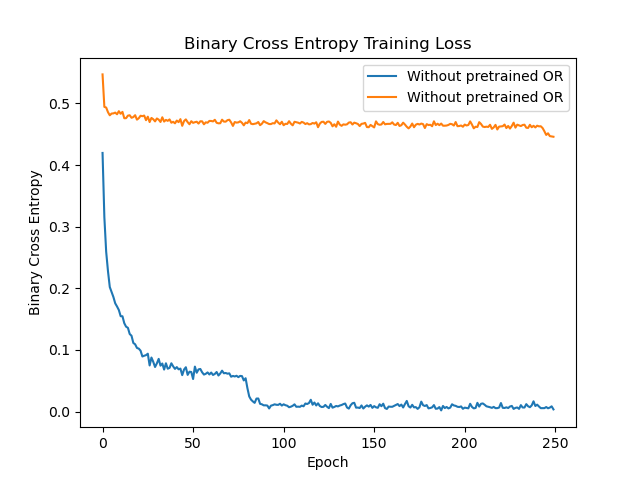

Text(0.5, 0, 'Epoch')

In [5]:
fig, axs = plt.subplots(1,1)
axs.plot(range(250), loss.T[0], label='Without pretrained OR')
axs.plot(range(250), loss.T[1], label='Without pretrained OR')
axs.set_title('Binary Cross Entropy Training Loss')
axs.legend()
axs.set_ylabel('Binary Cross Entropy')
axs.set_xlabel('Epoch')

In [26]:
def incr_ij(i,j, n_cols):
    if j == n_cols - 1:
        return i+1, 0
    else:
        return i, j+1
    
def hide_blank_plot(ax, last_plot_coord):
    n_cols = axes.shape[1]
    i, j = last_plot_coord
    while True:
        try:
            ax[i,j].set_visible(False)
            i,j = incr_ij(i,j,n_cols)
        except IndexError:
            break


<IPython.core.display.Javascript object>


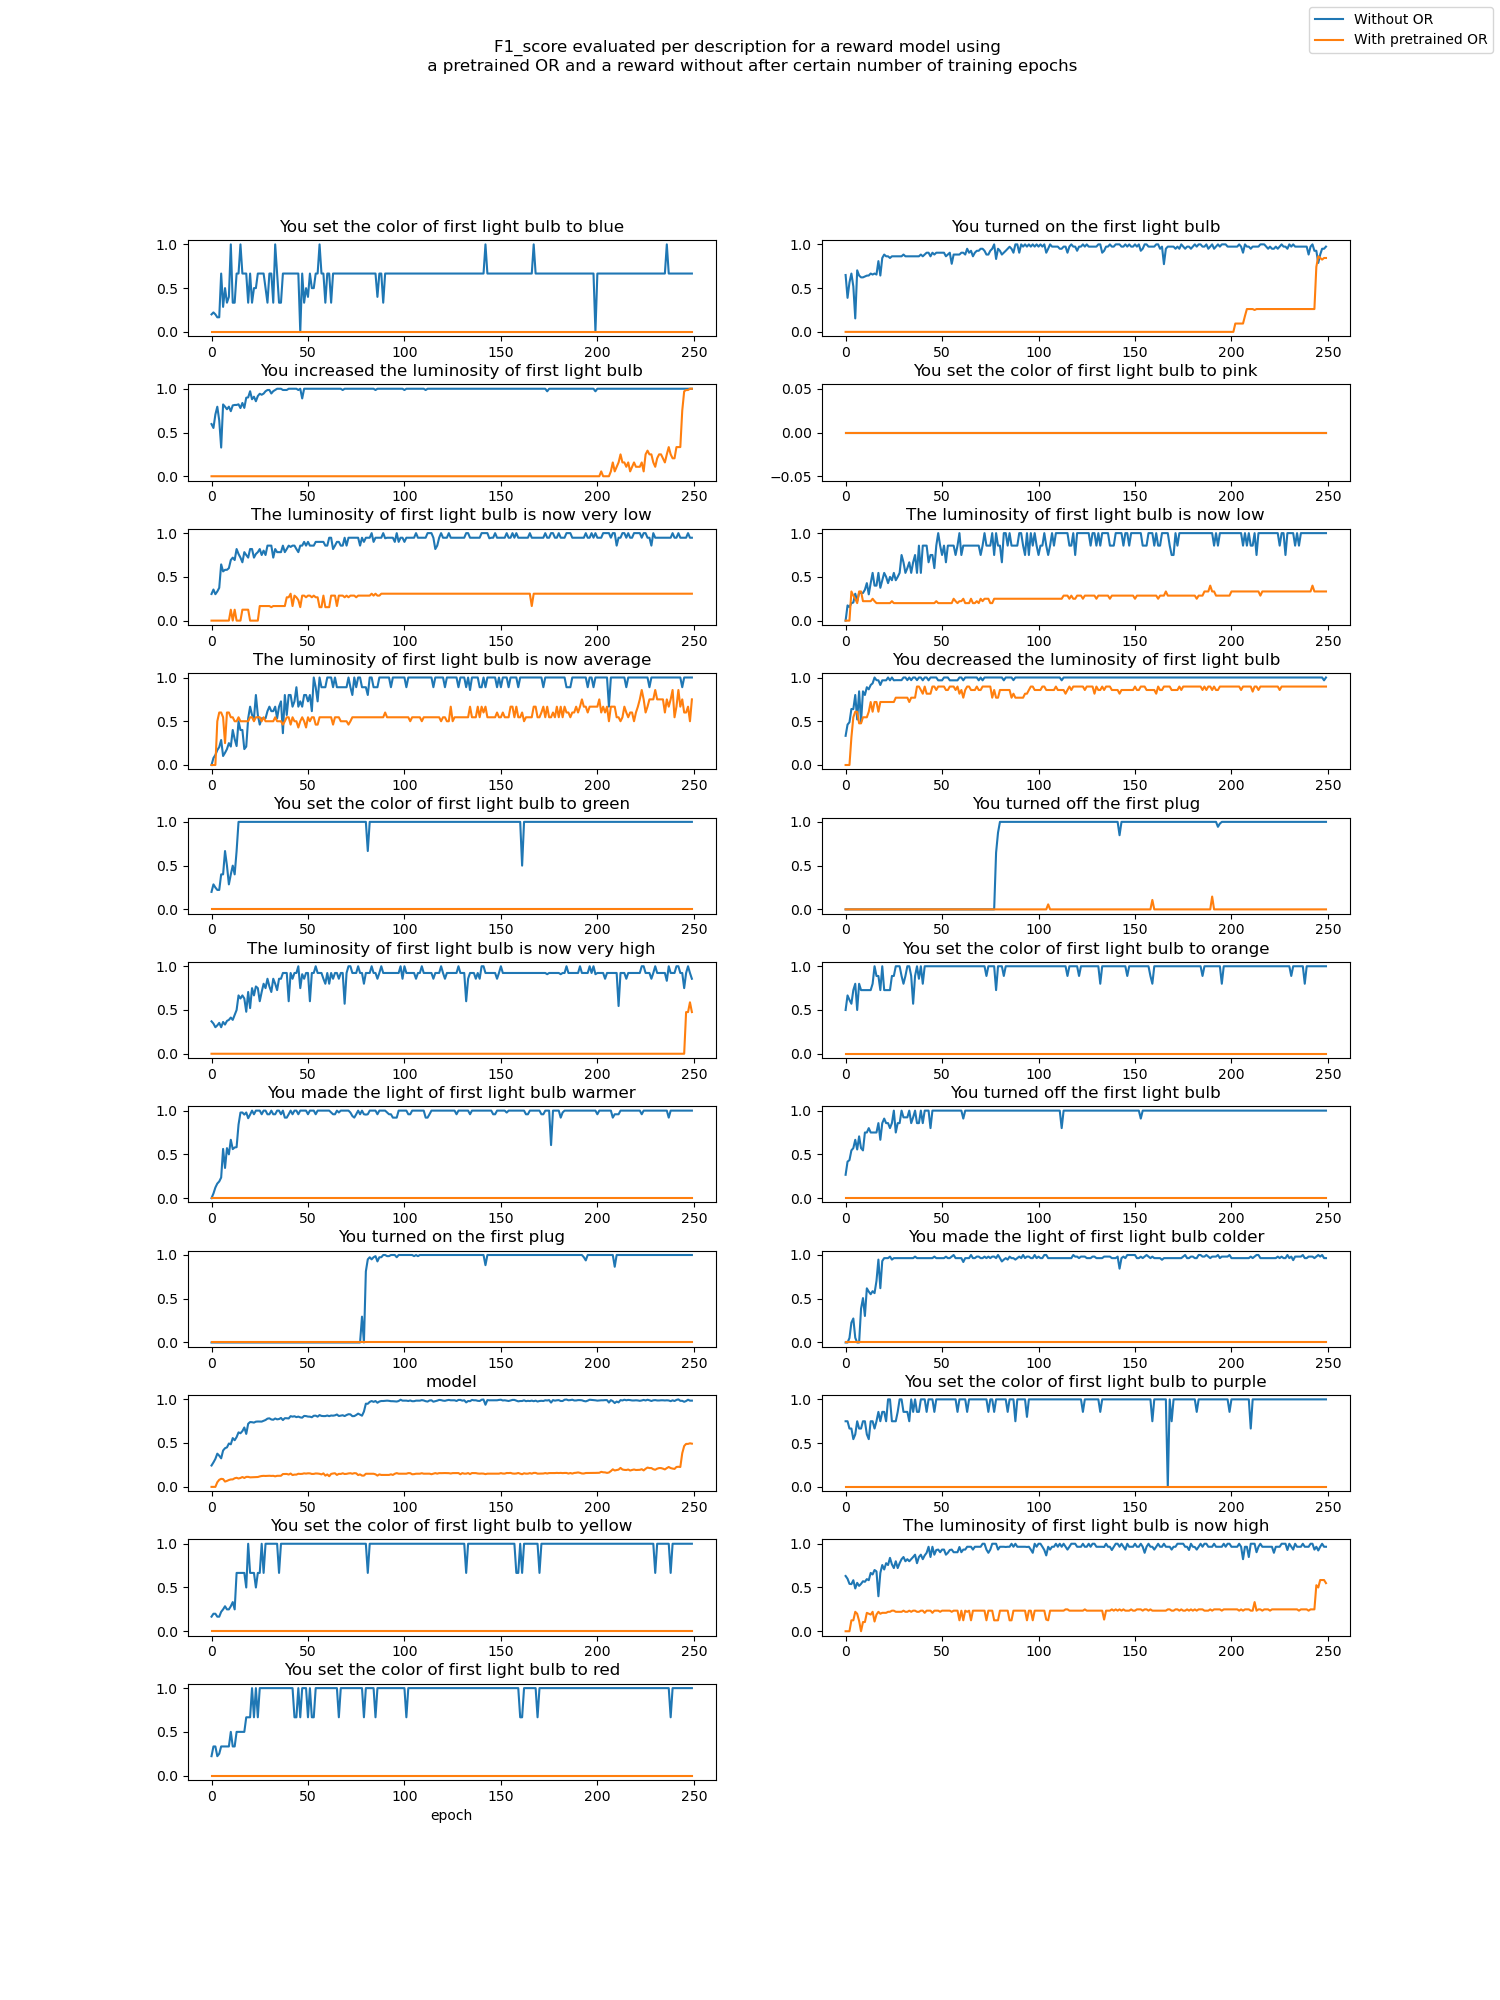

In [35]:
# Plot F1 score by instruction and for two different models

import math

instructions = list(set(metrics.index))

n_cols = 2
n_line = math.ceil(len(instructions) / n_cols)
fig, ax = plt.subplots(n_line, n_cols, figsize=(15, 20))
fig.suptitle('F1_score evaluated per description for a reward model using \n a pretrained OR and a reward without after certain number of training epochs')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
i,j = 0,0
legend = True
for instr in instructions:
    metrics.loc[instr].groupby('model').plot(y='f1_score', x='epoch',xlabel="",  ax=ax[i,j], legend=False, title=instr)
#     ax[i,j].set_title = instr
    if i == n_line- 1:
        ax[i,j].set_xlabel('epoch')
    i, j = incr_ij(i,j, n_cols)
    legend = False

handles, _ = ax[0,0].get_legend_handles_labels()
fig.legend(handles, ['Without OR', 'With pretrained OR'], loc='upper right')
# ax[n_line-1, n_cols-1].set_visible(False)
hide_blank_plot(ax, (i,j), n_cols)

In [14]:
torch.save(evaluator.model_list[0].language_model.state_dict(), 'results/learned_language_model')

In [13]:
pwd

'/home/nicolas/PycharmProjects/imagineIoT'

In [37]:
joblib.dump(loss, 'results/reward_comparison_loss.jbl')

['results/reward_comparison_loss.jbl']

In [18]:
l = loss[0]

In [19]:
l

array([tensor(0.4197, device='cuda:0', grad_fn=<DivBackward0>),
       tensor(0.5472, device='cuda:0', grad_fn=<DivBackward0>)],
      dtype=object)

In [20]:
l= [a.item() for a in l]

In [21]:
l

[0.419712096452713, 0.5471574664115906]

In [22]:
l = [np.array([a.item() for a in l_epoch]) for l_epoch in loss]

In [25]:
loss = np.array(l)

In [28]:
m0 = metrics[0].copy()
m1 = metrics[1].copy()

In [30]:
m0['model'] = 'learned_or'
m1['model'] = 'pretrained_or'

In [34]:
m = pd.concat([m0, m1], 0, ignore_index=True)

In [38]:
m.to_pickle('results/metrics_reward_comparison.pkl')